## Imports

In [1]:
%load_ext autoreload
%autoreload 2

%load_ext lab_black

In [2]:
import torch
import matplotlib.pyplot as plt
import ipywidgets as widgets

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=432)

## Callbacks

### Callbacks as GUI events

In [3]:
def f(o):
    print("hi")

From the [ipywidget docs](https://ipywidgets.readthedocs.io/en/stable/examples/Widget%20Events.html):

- *the button widget is used to handle mouse clicks. The on_click method of the Button can be used to register function to be called when the button is clicked*

In [4]:
w = widgets.Button(description="Click me")

In [5]:
w.on_click(f)

In [6]:
w

Button(description='Click me', style=ButtonStyle())

The function `f` is called *callback* in this situation. In other words, when we click the button, it calls the function `f`. In general, callbacks are specific kind of functions that are called when some events happened. We provide a pointer to the function which will be called when that event happens.

*NB: When callbacks are used in this way they are often called "events".*

Did you know what you can create interactive apps in Jupyter with these widgets? Here's an example from [plotly](https://plot.ly/python/widget-app/):

![](https://cloud.githubusercontent.com/assets/12302455/16637308/4e476280-43ac-11e6-9fd3-ada2c9506ee1.gif)

### Creating your own callback

In [7]:
from time import sleep

In [8]:
def slow_calculation():
    res = 0
    for i in range(5):
        res += i * i
        sleep(1)
    return res

In [9]:
slow_calculation()

30

In [10]:
def slow_calculation(cb=None):
    res = 0
    for i in range(5):
        res += i * i
        sleep(1)
        if cb:
            cb(i)
    return res

In [11]:
def show_progress(epoch):
    print(f"Awesome! We've finished epoch {epoch}!")

In [12]:
slow_calculation(show_progress)

Awesome! We've finished epoch 0!
Awesome! We've finished epoch 1!
Awesome! We've finished epoch 2!
Awesome! We've finished epoch 3!
Awesome! We've finished epoch 4!


30

`show_progress` is a callback here.

### Lambdas and partials

In [13]:
slow_calculation(lambda o: print(f"Awesome! We've finished epoch {o}!"))

Awesome! We've finished epoch 0!
Awesome! We've finished epoch 1!
Awesome! We've finished epoch 2!
Awesome! We've finished epoch 3!
Awesome! We've finished epoch 4!


30

In [14]:
def show_progress(exclamation, epoch):
    print(f"{exclamation}! We've finished epoch {epoch}!")

In [15]:
slow_calculation(lambda o: show_progress("OK I guess", o))

OK I guess! We've finished epoch 0!
OK I guess! We've finished epoch 1!
OK I guess! We've finished epoch 2!
OK I guess! We've finished epoch 3!
OK I guess! We've finished epoch 4!


30

In [16]:
def make_show_progress(exclamation):
    _inner = lambda epoch: print(f"{exclamation}! We've finished epoch {epoch}!")
    return _inner

In [17]:
slow_calculation(make_show_progress("Nice!"))

Nice!! We've finished epoch 0!
Nice!! We've finished epoch 1!
Nice!! We've finished epoch 2!
Nice!! We've finished epoch 3!
Nice!! We've finished epoch 4!


30

In [18]:
def make_show_progress(exclamation):
    # Leading "_" is generally understood to be "private"
    def _inner(epoch):
        print(f"{exclamation}! We've finished epoch {epoch}!")

    return _inner

`_inner` function inside `make_show_progress` is called a __closure__. _Closure_ is a function that takes external information and integrate it to its body. It is a function inside other function.

In [19]:
slow_calculation(make_show_progress("Nice!"))

Nice!! We've finished epoch 0!
Nice!! We've finished epoch 1!
Nice!! We've finished epoch 2!
Nice!! We've finished epoch 3!
Nice!! We've finished epoch 4!


30

In [20]:
f2 = make_show_progress("Terrific")

In [21]:
slow_calculation(f2)

Terrific! We've finished epoch 0!
Terrific! We've finished epoch 1!
Terrific! We've finished epoch 2!
Terrific! We've finished epoch 3!
Terrific! We've finished epoch 4!


30

In [22]:
from functools import partial

In [23]:
slow_calculation(partial(show_progress, "OK I guess"))

OK I guess! We've finished epoch 0!
OK I guess! We've finished epoch 1!
OK I guess! We've finished epoch 2!
OK I guess! We've finished epoch 3!
OK I guess! We've finished epoch 4!


30

In [24]:
f2 = partial(show_progress, "OK I guess")

In [25]:
f2(1)

OK I guess! We've finished epoch 1!


`partial` is used when we take one function that has multiple arguments and know that the first few args are the same so we can reduce the args passed each time we call the function. The args will be reduced to the ones missing.

### Callbacks as callable classes

In [26]:
class ProgressShowingCallback:
    def __init__(self, exclamation="Awesome"):
        self.exclamation = exclamation

    def __call__(self, epoch):
        print(f"{self.exclamation}! We've finished epoch {epoch}!")

In [27]:
cb = ProgressShowingCallback("Just super")

In [28]:
slow_calculation(cb)

Just super! We've finished epoch 0!
Just super! We've finished epoch 1!
Just super! We've finished epoch 2!
Just super! We've finished epoch 3!
Just super! We've finished epoch 4!


30

The callback can be either a function or a class.

### Multiple callback funcs; `*args` and `**kwargs`

In [29]:
def f(*args, **kwargs):
    print(f"args: {args}; kwargs: {kwargs}")

In [30]:
f(3, "a", thing1="hello")

args: (3, 'a'); kwargs: {'thing1': 'hello'}


- `*args`: Positional arguments. Returns a tuple.
- `**kwargs`: Keyword arguments. Returns a dictionary.

NB: We've been guilty of over-using kwargs in fastai - it's very convenient for the developer, but is annoying for the end-user unless care is taken to ensure docs show all kwargs too. kwargs can also hide bugs (because it might not tell you about a typo in a param name). In [R](https://www.r-project.org/) there's a very similar issue (R uses `...` for the same thing), and matplotlib uses kwargs a lot too.

In [31]:
def slow_calculation(cb=None):
    res = 0
    for i in range(5):
        if cb:
            cb.before_calc(i)
        res += i * i
        sleep(1)
        if cb:
            cb.after_calc(i, val=res)
    return res

In [32]:
class PrintStepCallback:
    def __init__(self):
        pass

    def before_calc(self, *args, **kwargs):
        print(f"About to start")

    def after_calc(self, *args, **kwargs):
        print(f"Done step")

Here we use both `*args` and `**kwargs` even though we don't use any of them inside the body of the function. This helps us in making the function more flexible and also if we want to add something in the future so the function won't give an error.

In [33]:
slow_calculation(PrintStepCallback())

About to start
Done step
About to start
Done step
About to start
Done step
About to start
Done step
About to start
Done step


30

In [34]:
class PrintStatusCallback:
    def __init__(self):
        pass

    def before_calc(self, epoch, **kwargs):
        print(f"About to start: {epoch}")

    def after_calc(self, epoch, val, **kwargs):
        print(f"After {epoch}: {val}")

In [35]:
slow_calculation(PrintStatusCallback())

About to start: 0
After 0: 0
About to start: 1
After 1: 1
About to start: 2
After 2: 5
About to start: 3
After 3: 14
About to start: 4
After 4: 30


30

__**kwargs__ are used more often than __*args__ to gain flexibility.

### Modifying behavior

In [36]:
def slow_calculation(cb=None):
    res = 0
    for i in range(5):
        if cb and hasattr(cb, "before_calc"):
            cb.before_calc(i)
        res += i * i
        sleep(1)
        if cb and hasattr(cb, "after_calc"):
            if cb.after_calc(i, res):
                print("stopping early")
                break
    return res

In [37]:
class PrintAfterCallback:
    def after_calc(self, epoch, val):
        print(f"After {epoch}: {val}")
        if val > 10:
            return True

In [38]:
slow_calculation(PrintAfterCallback())

After 0: 0
After 1: 1
After 2: 5
After 3: 14
stopping early


14

In [39]:
class SlowCalculator:
    def __init__(self, cb=None):
        self.cb, self.res = cb, 0

    def callback(self, cb_name, *args):
        if not self.cb:
            return
        cb = getattr(self.cb, cb_name, None)
        if cb:
            return cb(self, *args)

    def calc(self):
        for i in range(5):
            self.callback("before_calc", i)
            self.res += i * i
            sleep(1)
            if self.callback("after_calc", i):
                print("stopping early")
                break

In [40]:
class ModifyingCallback:
    def after_calc(self, calc, epoch):
        print(f"After {epoch}: {calc.res}")
        if calc.res > 10:
            return True
        if calc.res < 3:
            calc.res = calc.res * 2

In [41]:
calculator = SlowCalculator(ModifyingCallback())

In [42]:
calculator.calc()
calculator.res

After 0: 0
After 1: 1
After 2: 6
After 3: 15
stopping early


15

In [43]:
class SlowCalculator:
    def __init__(self, cb=None):
        self.cb, self.res = cb, 0

    def __call__(self, cb_name, *args):
        if not self.cb:
            return
        cb = getattr(self.cb, cb_name, None)
        if cb:
            return cb(self, *args)

    def calc(self):
        for i in range(5):
            self("before_calc", i)
            self.res += i * i
            sleep(1)
            if self("after_calc", i):
                print("stopping early")
                break

In [44]:
calculator = SlowCalculator(ModifyingCallback())

In [45]:
calculator.calc()
calculator.res

After 0: 0
After 1: 1
After 2: 6
After 3: 15
stopping early


15

We can either use `self(cb_name)` if we defined `__call__` method, or use `self.callback(cb_name)` if we define `callback` method in the class.

## `__dunder__` thingies

Anything that looks like `__this__` is, in some way, *special*. Python, or some library, can define some functions that they will call at certain documented times. For instance, when your class is setting up a new object, python will call `__init__`. These are defined as part of the python [data model](https://docs.python.org/3/reference/datamodel.html#object.__init__).

For instance, if python sees `+`, then it will call the special method `__add__`. If you try to display an object in Jupyter (or lots of other places in Python) it will call `__repr__`.

In [46]:
class SloppyAdder:
    def __init__(self, o):
        self.o = o

    def __add__(self, b):
        return SloppyAdder(self.o + b.o + 0.01)

    def __repr__(self):
        return str(self.o)

In [47]:
a = SloppyAdder(1)
b = SloppyAdder(2)
a + b

3.01

Special methods you should probably know about (see data model link above) are:

- `__init__`: Called after the instance has been created (by __new__()), but before it is returned to the caller. The arguments are those passed to the class constructor expression.

- `__new__`: Called to create a new instance of class `cls`. It takes the first argument the class we want to create instance of and the remaining arguments to pass to the `__init__` method of the class constructor.

- `__del__`: `del x` doesn’t directly call `x.__del__()` — the former decrements the reference count for x by one, and the latter is only called when x’s reference count reaches zero.

- `__repr__`: Called by the `repr()` built-in function to compute the “official” string representation of an object. If a class defines `__repr__()` but not `__str__()`, then `__repr__()` is also used when an “informal” string representation of instances of that class is required. This should look like a valid Python expression that could be used to recreate an object with the same value (given an appropriate environment).

- `__str__`: Called by `str(object)` and the built-in functions format() and print() to compute the “informal” or nicely printable string representation of an object. The return value must be a string object. This method differs from `object.__repr__()` in that there is no expectation that `__str__()` return a valid Python expression: a more convenient or concise representation can be used. The default implementation defined by the built-in type object calls `object.__repr__()`.

- `__getitem__`: Called to implement evaluation of `self[key]`. For sequence types, the accepted keys should be integers and slice objects. Note that the special interpretation of negative indexes (if the class wishes to emulate a sequence type) is up to the `__getitem__()` method.

- `__len__`: Called to implement the built-in function `len()`. Should return the length of the object, an integer >= 0. Also, an object that doesn’t define a `__bool__()` method and whose `__len__()` method returns zero is considered to be false in a Boolean context.

- `__getattribute__`: Called unconditionally to implement attribute accesses for instances of the class. If the class also defines `__getattr__()`, the latter will not be called unless `__getattribute__()` either calls it explicitly or raises an `AttributeError`. This method should return the (computed) attribute value or raise an `AttributeError` exception. In order to avoid infinite recursion in this method, its implementation should always call the base class method with the same name to access any attributes it needs, for example, `object.__getattribute__`.

- `__getattr__`: Called when the default attribute access fails with an `AttributeError` (either `__getattribute__()` raises an `AttributeError` because name is not an instance attribute or an attribute in the class tree for self; or `__get__()` of a name property raises `AttributeError`). This method should either return the (computed) attribute value or raise an `AttributeError` exception. Note that if the attribute is found through the normal mechanism, `__getattr__()` is not called. (This is an intentional asymmetry between `__getattr__()` and `__setattr__()`.) This is done both for efficiency reasons and because otherwise `__getattr__()` would have no way to access other attributes of the instance. Note that at least for instance variables, you can fake total control by not inserting any values in the instance attribute dictionary (but instead inserting them in another object). See the `__getattribute__()` method below for a way to actually get total control over attribute access.

- `__setattr__`: Called when an attribute assignment is attempted. This is called instead of the normal mechanism (i.e. store the value in the instance dictionary). `name` is the attribute name, `value` is the value to be assigned to it. If `__setattr__()` wants to assign to an instance attribute, it should call the base class method with the same name, for example, `object.__setattr__(self, name, value)`.

- `__delattr__`: Like `__setattr__()` but for attribute deletion instead of assignment. This should only be implemented if `del obj.name` is meaningful for the object.

- A context manager is an object that defines the runtime context to be established when executing a `with` statement. The context manager handles the entry into, and the exit from, the desired runtime context for the execution of the block of code. Context managers are normally invoked using the with statement, but can also be used by directly invoking their methods. 
    - `__enter__` enter the runtime context related to this object. The `with` statement will bind this method’s return value to the target(s) specified in the `as` clause of the statement, if any.
    - `__exit__(self, exc_type, exc_value, traceback)`: Exit the runtime context related to this object. The parameters describe the exception that caused the context to be exited. If the context was exited without an exception, all three arguments will be None. If an exception is supplied, and the method wishes to suppress the exception (i.e., prevent it from being propagated), it should return a true value. Otherwise, the exception will be processed normally upon exit from this method.

## Variance and stuff

### Variance

Variance is the average of how far away each data point is from the mean. E.g.:

In [48]:
t = torch.tensor([1., 2., 4., 18])

<IPython.core.display.Javascript object>

In [49]:
m = t.mean()
m

tensor(6.2500)

<IPython.core.display.Javascript object>

In [50]:
(t - m).mean()

tensor(0.)

<IPython.core.display.Javascript object>

Oops. We can't do that. Because by definition the positives and negatives cancel out. So we can fix that in one of (at least) two ways:

In [51]:
(t - m).pow(2).mean()

tensor(47.1875)

<IPython.core.display.Javascript object>

In [52]:
(t - m).abs().mean()

tensor(5.8750)

<IPython.core.display.Javascript object>

But the first of these is now a totally different scale, since we squared. So let's undo that at the end.

In [53]:
(t - m).pow(2).mean().sqrt()

tensor(6.8693)

<IPython.core.display.Javascript object>

They're still different. Why?

Note that we have one outlier (`18`). In the version where we square everything, it makes that much bigger than everything else.

`(t-m).pow(2).mean()` is refered to as **variance**. It's a measure of how spread out the data is, and is particularly sensitive to outliers.

When we take the sqrt of the variance, we get the **standard deviation**. Since it's on the same kind of scale as the original data, it's generally more interpretable. However, since `sqrt(1)==1`, it doesn't much matter which we use when talking about *unit variance* for initializing neural nets.

`(t-m).abs().mean()` is referred to as the **mean absolute deviation**. It isn't used nearly as much as it deserves to be, because mathematicians don't like how awkward it is to work with. But that shouldn't stop us, because we have computers and stuff.

Here's a useful thing to note about variance:

In [54]:
(t - m).pow(2).mean(), (t * t).mean() - (m * m)

(tensor(47.1875), tensor(47.1875))

<IPython.core.display.Javascript object>

You can see why these are equal if you want to work thru the algebra. Or not.

But, what's important here is that the latter is generally much easier to work with. In particular, you only have to track two things: the sum of the data, and the sum of squares of the data. Whereas in the first form you actually have to go thru all the data twice (once to calculate the mean, once to calculate the differences).

Let's go steal the LaTeX from [Wikipedia](https://en.wikipedia.org/wiki/Variance):

$$\operatorname{E}\left[X^2 \right] - \operatorname{E}[X]^2$$

### Covariance and correlation

Here's how Wikipedia defines covariance:

$$\operatorname{cov}(X,Y) = \operatorname{E}{\big[(X - \operatorname{E}[X])(Y - \operatorname{E}[Y])\big]}$$

In [55]:
t

tensor([ 1.,  2.,  4., 18.])

<IPython.core.display.Javascript object>

Let's see that in code. So now we need two vectors.

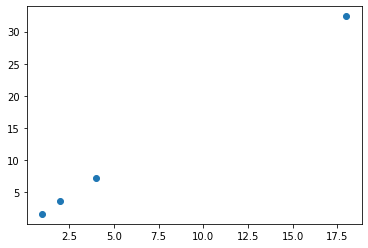

<IPython.core.display.Javascript object>

In [56]:
# `u` is twice `t`, plus a bit of randomness
u = t * 2
u *= torch.randn_like(t) / 10 + 0.95

plt.scatter(t, u)

In [57]:
prod = (t - t.mean()) * (u - u.mean())
prod

tensor([ 50.4843,  32.0649,   8.9855, 248.5630])

<IPython.core.display.Javascript object>

In [58]:
prod.mean()

tensor(85.0244)

<IPython.core.display.Javascript object>

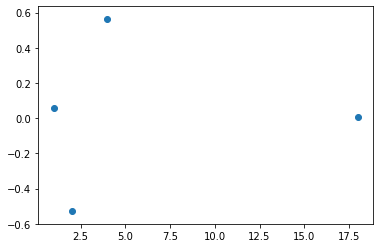

<IPython.core.display.Javascript object>

In [59]:
v = torch.randn_like(t)
plt.scatter(t, v)

In [60]:
((t - t.mean()) * (v - v.mean())).mean()

tensor(0.1963)

<IPython.core.display.Javascript object>

It's generally more conveniently defined like so:

$$\operatorname{E}\left[X Y\right] - \operatorname{E}\left[X\right] \operatorname{E}\left[Y\right]$$

In [61]:
cov = (t * v).mean() - t.mean() * v.mean()
cov

tensor(0.1963)

<IPython.core.display.Javascript object>

From now on, you're not allowed to look at an equation (or especially type it in LaTeX) without also typing it in Python and actually calculating some values. Ideally, you should also plot some values.

Finally, here is the Pearson correlation coefficient:

$$\rho_{X,Y}= \frac{\operatorname{cov}(X,Y)}{\sigma_X \sigma_Y}$$

In [62]:
cov / (t.std() * v.std())

tensor(0.0553)

<IPython.core.display.Javascript object>

It's just a scaled version of the same thing. Question: *Why is it scaled by standard deviation, and not by variance or mean or something else?*

## Softmax

Here's our final `logsoftmax` definition:

In [63]:
def log_softmax(x):
    return x - x.exp().sum(-1, keepdim=True).log()

<IPython.core.display.Javascript object>

which is:

$$\hbox{logsoftmax(x)}_{i} = x_{i} - \log \sum_{j} e^{x_{j}}$$ 

And our cross entropy loss is:
$$-\log(p_{i})$$

Softmax may not be a good metric to use unless:
- There is definitely Only one object.

Because Softmax will always gives high probability for on entry even if there is no object or there are multiple objects. Therefore, if there is a possibility that for example the image may have no object or it may have more than one object in the same time, then Softmax is not a good loss function. Use Binomial where we take the exponent of the activation and then divide it by the 1 + exponent of the activation.
$$\frac{e^{output}}{1 + e^{output}}$$
In language modeling for example, Softmax is good because there is always only one work next to the current word.

## Browsing source code

In [64]:
hasattr??

<IPython.core.display.Javascript object>

Signature: hasattr(obj, name, /)
Docstring:
Return whether the object has an attribute with the given name.

This is done by calling getattr(obj, name) and catching AttributeError.
Type:      builtin_function_or_method


- Jump to tag/symbol by with (with completions)
- Jump to current tag
- Jump to library tags
- Go back
- Search
- Outlining / folding